<a href="https://colab.research.google.com/github/SaurabhSharma2388/AutoML/blob/main/Amazon_Time_Series_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install dash
!pip install dash_core_components
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
#from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
#import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import plotly.express as px
import dash
import dash_core_components as dcc
import dash_html_components as html

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

from numpy.random import seed

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 46.6 MB/s eta 0:00:00


<ipython-input-1-05b9f1cdd88b>:20: UserWarning:


The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`

<ipython-input-1-05b9f1cdd88b>:21: UserWarning:


The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`



In [2]:
from google.colab import drive

drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
data = pd.read_csv('/content/drive/MyDrive/Amazon Sale 2023/Amazon Sale Report.csv')

In [4]:
data.head(5)

,index,Order ID,Date,Status,Fulfilment,Sales Channel,ship-service-level,Style,SKU,Category,...,currency,Amount,ship-city,ship-state,ship-postal-code,ship-country,promotion-ids,B2B,fulfilled-by,Unnamed: 22
0,0,405-8078784-5731545,04-30-22,Cancelled,Merchant,Amazon.in,Standard,SET389,SET389-KR-NP-S,Set,...,INR,647.62,MUMBAI,MAHARASHTRA,400081.0,IN,NaN,False,Easy Ship,NaN
1,1,171-9198151-1101146,04-30-22,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,JNE3781,JNE3781-KR-XXXL,kurta,...,INR,406.00,BENGALURU,KARNATAKA,560085.0,IN,Amazon PLCC Free-Financing Universal Merchant ...,False,Easy Ship,NaN
2,2,404-0687676-7273146,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3371,JNE3371-KR-XL,kurta,...,INR,329.00,NAVI MUMBAI,MAHARASHTRA,410210.0,IN,IN Core Free Shipping 2015/04/08 23-48-5-108,True,NaN,NaN
3,3,403-9615377-8133951,04-30-22,Cancelled,Merchant,Amazon.in,Standard,J0341,J0341-DR-L,Western Dress,...,INR,753.33,PUDUCHERRY,PUDUCHERRY,605008.0,IN,NaN,False,Easy Ship,NaN
4,4,407-1069790-7240320,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3671,JNE3671-TU-XXXL,Top,...,INR,574.00,CHENNAI,TAMIL NADU,600073.0,IN,NaN,False,NaN,NaN


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128975 entries, 0 to 128974
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   index               128975 non-null  int64  
 1   Order ID            128975 non-null  object 
 2   Date                128975 non-null  object 
 3   Status              128975 non-null  object 
 4   Fulfilment          128975 non-null  object 
 5   Sales Channel       128975 non-null  object 
 6   ship-service-level  128975 non-null  object 
 7   Style               128975 non-null  object 
 8   SKU                 128975 non-null  object 
 9   Category            128975 non-null  object 
 10  Size                128975 non-null  object 
 11  ASIN                128975 non-null  object 
 12  Courier Status      122103 non-null  object 
 13  Qty                 128975 non-null  int64  
 14  currency            121180 non-null  object 
 15  Amount              121180 non-nul

In [6]:
data.isnull().sum()

index                     0
Order ID                  0
Date                      0
Status                    0
Fulfilment                0
Sales Channel             0
ship-service-level        0
Style                     0
SKU                       0
Category                  0
Size                      0
ASIN                      0
Courier Status         6872
Qty                       0
currency               7795
Amount                 7795
ship-city                33
ship-state               33
ship-postal-code         33
ship-country             33
promotion-ids         49153
B2B                       0
fulfilled-by          89698
Unnamed: 22           49050
dtype: int64

In [7]:
data.shape

(128975, 24)

In [8]:
data.dropna(inplace=True)

In [9]:
data.shape

(19379, 24)

# EDA

## Outliers Check

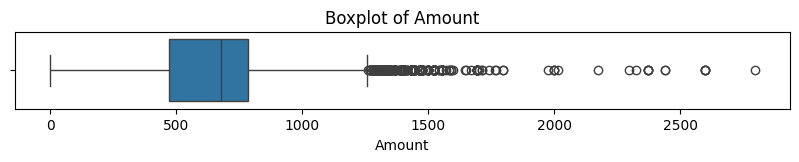

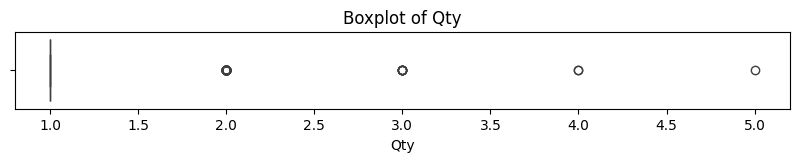

In [10]:
for column in ['Amount', 'Qty']:
    plt.figure(figsize=(10, 1))
    sns.boxplot(data=data, x=column)
    plt.xlabel(column)
    plt.title(f'Boxplot of {column}')
    plt.show()

In [11]:
# change data type
data['ship-postal-code']=data['ship-postal-code'].astype('int')

In [12]:
data['Date'] = pd.to_datetime(data['Date'])

print('Min date from train set: %s' % data['Date'].min().date())
print('Max date from train set: %s' % data['Date'].max().date())


Min date from train set: 2022-04-30
Max date from train set: 2022-06-29


In [13]:
lag_size = (data['Date'].max().date() - data['Date'].min().date()).days
print('Max date from train set: %s' % data['Date'].max().date())
print('min date from test set: %s' % data['Date'].min().date())
print('Forecast size', lag_size)


Max date from train set: 2022-06-29
min date from test set: 2022-04-30
Forecast size 60


In [14]:
daily_sales = data.groupby('Date', as_index=False)['Amount'].sum()
store_daily_sales = data.groupby(['Fulfilment', 'Date'], as_index=False)['Amount'].sum()
item_daily_sales = data.groupby(['Category', 'Date'], as_index=False)['Amount'].sum()

Text(0, 0.5, 'Amount')

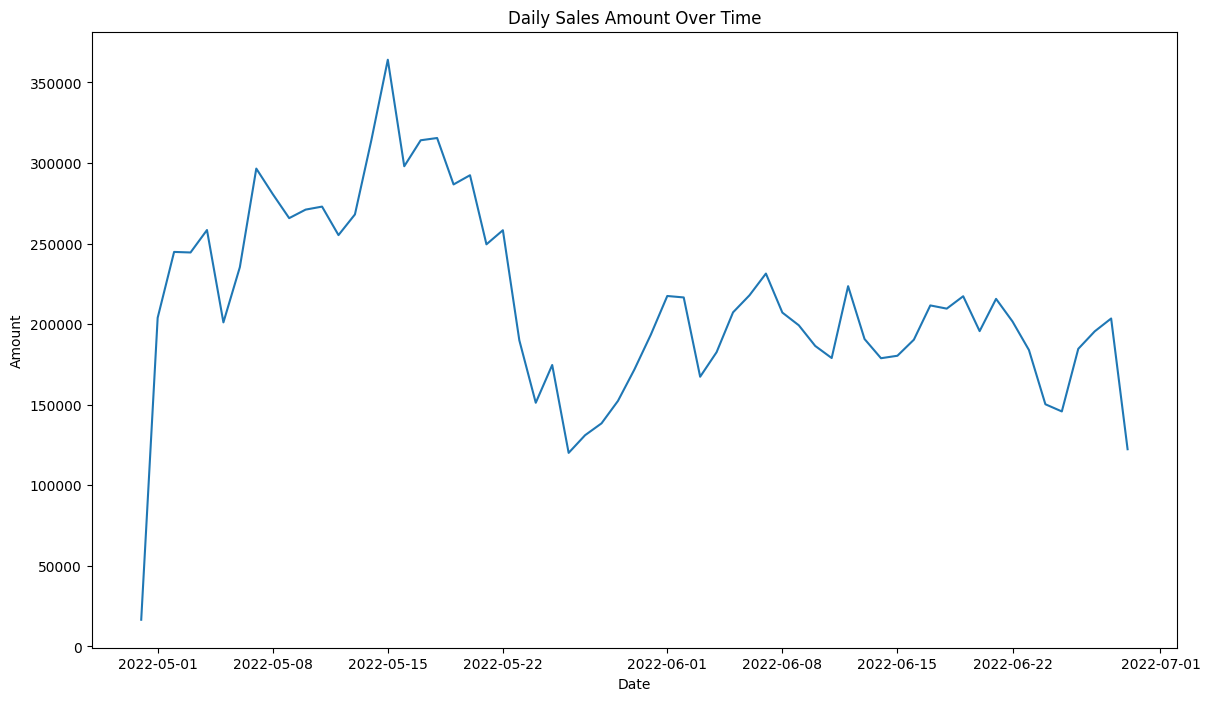

In [15]:

plt.figure(figsize=(14, 8))

sns.lineplot(x='Date', y='Amount', data=daily_sales)
plt.title('Daily Sales Amount Over Time')
plt.xlabel('Date')
plt.ylabel('Amount')

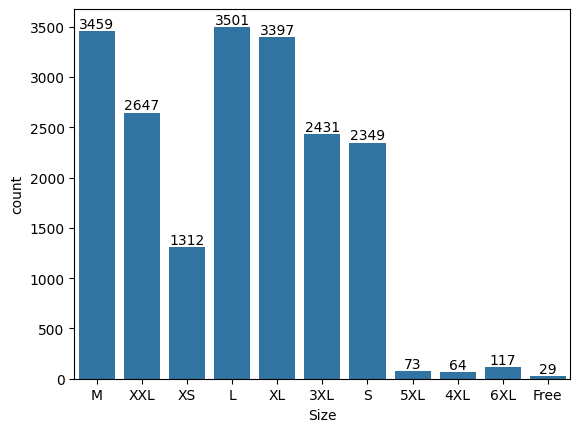

In [16]:
ax=sns.countplot(x='Size' ,data=data)
for bars in ax.containers:
    ax.bar_label(bars)

### Augmented Dickey-Fuller Test

ADF Test: The ADF test is performed to check for stationarity.


In [17]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(data['Amount'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print('Critical Values:')
    print(f'   {key}, {value}')

ADF Statistic: -93.42597679666439
p-value: 0.0
Critical Values:
   1%, -3.4306875221394604
Critical Values:
   5%, -2.8616891726589833
Critical Values:
   10%, -2.566849400576234


#### Box-Jenkins Model (ARIMA)
ARIMA Model: The ARIMA model is fitted to the data, and model adequacy is checked using residual plots and diagnostics.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.



                               SARIMAX Results                                
Dep. Variable:                 Amount   No. Observations:                19379
Model:                 ARIMA(1, 1, 1)   Log Likelihood             -137196.814
Date:                Sun, 26 May 2024   AIC                         274399.627
Time:                        19:43:38   BIC                         274423.243
Sample:                             0   HQIC                        274407.366
                              - 19379                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0421      0.007      6.070      0.000       0.028       0.056
ma.L1         -0.9974      0.001  -1892.012      0.000      -0.998      -0.996
sigma2      8.261e+04    617.134    133.868      0.0

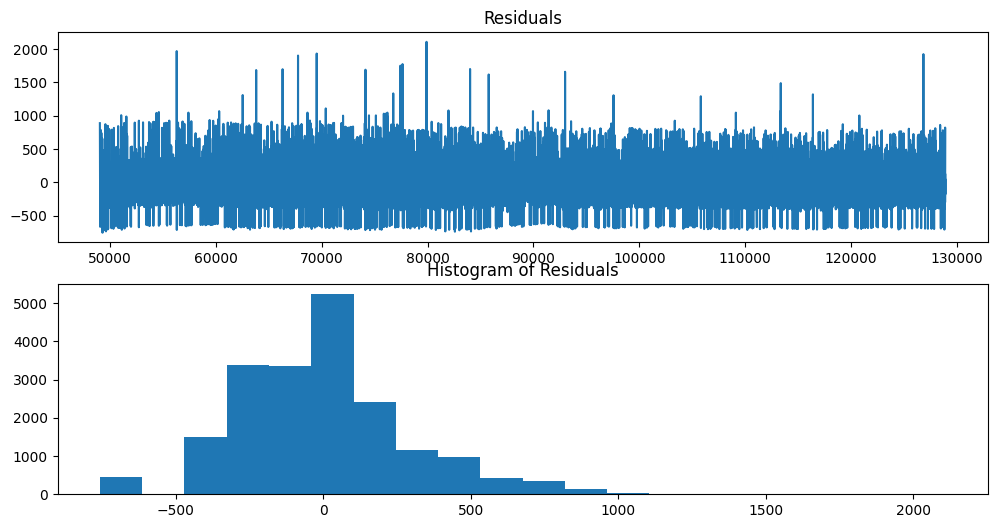

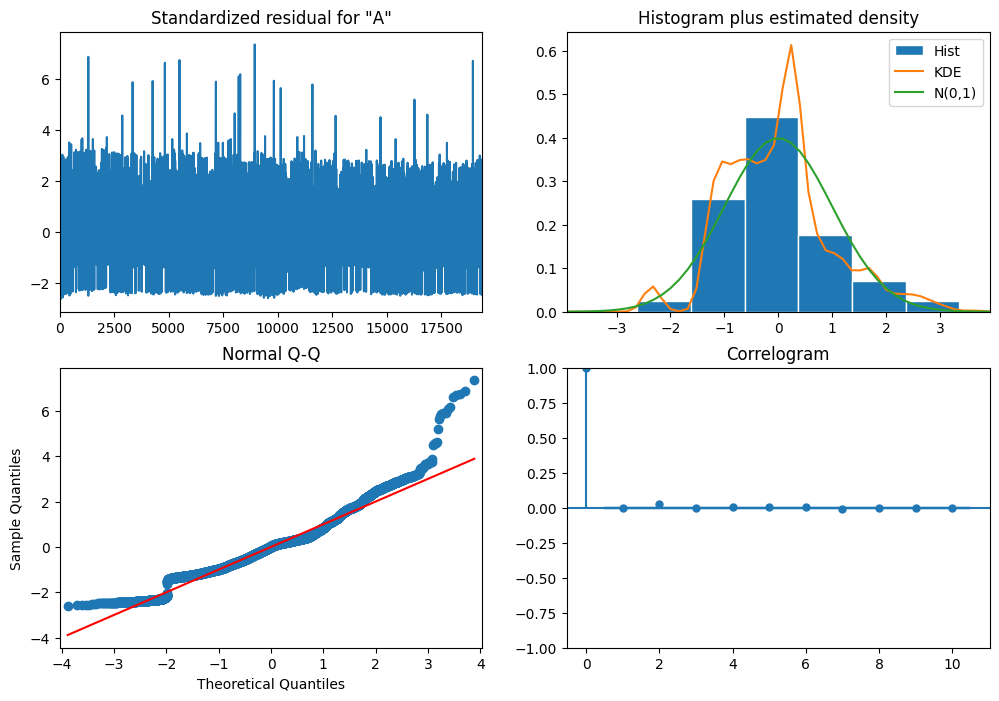

In [18]:

from statsmodels.tsa.arima.model import ARIMA


# Fit the ARIMA model
model = ARIMA(data['Amount'], order=(1, 1, 1))  # ARIMA(p,d,q) parameters can be tuned
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

# Plot residuals to check for model adequacy
residuals = model_fit.resid
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.plot(residuals)
plt.title('Residuals')
plt.subplot(212)
plt.hist(residuals, bins=20)
plt.title('Histogram of Residuals')
plt.show()

# Perform diagnostics
model_fit.plot_diagnostics(figsize=(12, 8))
plt.show()


#### One-Step-Ahead Forecasts

Forecasting: One-step-ahead forecasts are made, and the forecast errors are calculated and visualized.


In [19]:
# Making one-step-ahead forecasts
forecast_steps = 5000
forecast = model_fit.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=data.index[-1], periods=forecast_steps + 1, freq='D')

# Create forecast dataframe
forecast_df = forecast.summary_frame()

# Print forecast
print(forecast_df[['mean', 'mean_ci_lower', 'mean_ci_upper']])

# Calculate forecast errors
actual = data['Amount'][-forecast_steps:]
forecast_errors = actual - forecast_df['mean']
print('Forecast Errors:')
print(forecast_errors)

Amount        mean  mean_ci_lower  mean_ci_upper
19379   691.739403     128.391784    1255.087021
19380   690.508085     126.598464    1254.417706
19381   690.456269     126.541005    1254.371533
19382   690.454089     126.536640    1254.371538
19383   690.453997     126.534474    1254.373520
...            ...            ...            ...
24374   690.453993     116.297206    1264.610780
24375   690.453993     116.295173    1264.612813
24376   690.453993     116.293140    1264.614846
24377   690.453993     116.291108    1264.616879
24378   690.453993     116.289075    1264.618912

[5000 rows x 3 columns]
Forecast Errors:
19379    NaN
19380    NaN
19381    NaN
19382    NaN
19383    NaN
          ..
128872   NaN
128873   NaN
128874   NaN
128887   NaN
128891   NaN
Length: 10000, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



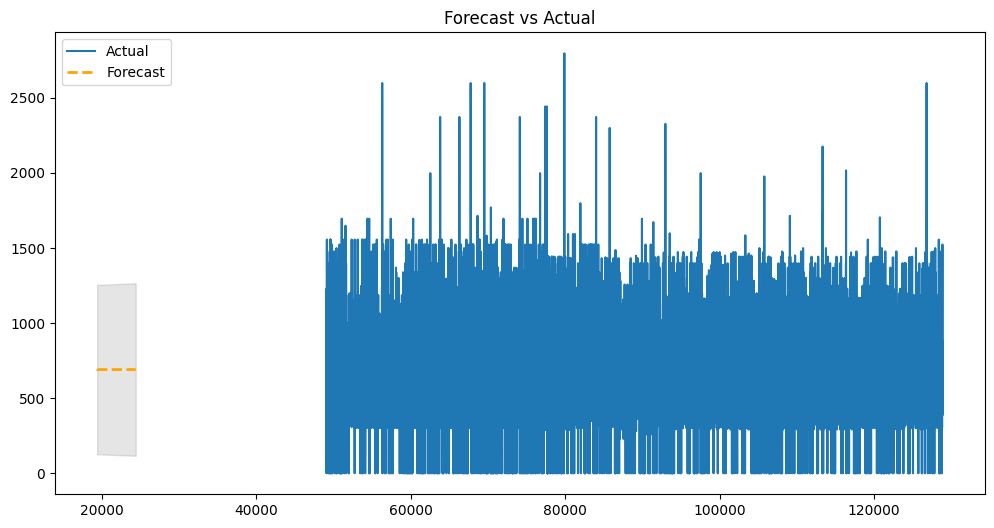

In [20]:
# Plot the forecast vs actual
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Amount'], label='Actual')
plt.plot(forecast_df.index, forecast_df['mean'], label='Forecast', linestyle='--', linewidth=2, color='orange')  # Adjust line appearance here
plt.fill_between(forecast_df.index, forecast_df['mean_ci_lower'], forecast_df['mean_ci_upper'], color='k', alpha=0.1)
plt.legend()
plt.title('Forecast vs Actual')
plt.show()


## Dashboard

In [21]:
# Create a Dash application
app = dash.Dash(__name__)

# Generate visualizations
def create_visualizations():
    visualizations = []

    # Sales by Category
    sales_by_category = data.groupby('Category')['Amount'].sum().reset_index()
    fig_category = px.bar(sales_by_category, x='Category', y='Amount', title='Sales by Category', color='Category')
    visualizations.append(dcc.Graph(figure=fig_category))

    # Count by Courier Status
    count_by_courier_status = data.groupby('Courier Status').size().reset_index(name='Count')
    fig_courier_status = px.bar(count_by_courier_status, x='Courier Status', y='Count', title='Count by Courier Status', color='Courier Status')
    visualizations.append(dcc.Graph(figure=fig_courier_status))

    # Fulfilment Status
    fulfilment_status = data['Status'].value_counts().reset_index()
    fulfilment_status.columns = ['Status', 'Count']
    fig_status = px.pie(fulfilment_status, values='Count', names='Status', title='Fulfilment Status', color='Status')
    visualizations.append(dcc.Graph(figure=fig_status))

    # Shipping City
    top_shipping_cities = data['ship-city'].value_counts().head(10).reset_index()
    top_shipping_cities.columns = ['Shipping City', 'Count']
    fig_city = px.bar(top_shipping_cities, x='Shipping City', y='Count', title='Top Shipping Cities', color='Shipping City')
    visualizations.append(dcc.Graph(figure=fig_city))

    return visualizations

In [22]:

app.layout = html.Div([
    html.H1("Online Retail Business Dashboard", style={'textAlign': 'center'}),

    # Display visualizations side by side
    html.Div([
        html.Div(create_visualizations()[:2], className='row', style={'display': 'flex', 'justify-content': 'space-around'}),
        html.Div(create_visualizations()[2:], className='row', style={'display': 'flex', 'justify-content': 'space-around'}),
    ], style={'margin': '50px auto', 'width': '90%'}),

    # Explanation of why the dataset is suitable for ML models
    html.Div([
        html.H2("Why this dataset is suitable for Machine Learning models?"),
        html.P("This dataset contains valuable information about online retail transactions, including sales data, fulfilment status, shipping details, etc."),
        html.P("The dataset can be used to train machine learning models for various tasks such as sales forecasting, customer segmentation, and fraud detection."),
        html.P("With the right feature engineering and model selection, we can build ML models to optimize inventory management, improve customer experience, and increase sales."),
        html.P("By analyzing this dataset, we can gain insights into customer behavior, preferences, and trends, which are crucial for making data-driven decisions in an online retail business.")
    ], style={'margin': '50px auto', 'width': '80%'})
])

if __name__ == '__main__':
    app.run_server(debug=True)


<IPython.core.display.Javascript object>